In [48]:
import requests
from pyspark.sql import SparkSession
from pyspark.sql import DataFrameReader
from urllib.request import urlopen
from pymongo import MongoClient
from datetime import date
import pymongo
import pandas as pd
import os

In [49]:
def data_into_mongo(location, client):
    days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    start_date = "2010-01-01"
    db = client['Real_Time_Weather']
    col = db[location]
    
    for year in [2019, 2020, 2021]:
        j = 1
        for i in days:
            start_date = "{}-{}-01".format(year,j)
            end_date = "{}-{}-{}".format(year,j,i)
            j += 1
            
            url = "https://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=6052652525c04c6b88b74541222512&q={}&format=json&date={}&enddate={}&includelocation=yes&tp=24".format(location, start_date, end_date)
            response = requests.request("GET", url)
            data = response.json()
            for k in data["data"]["weather"]:
                col.insert_one(k)

In [50]:
payload={}
headers = {}

client = MongoClient("mongodb://localhost:27017/")        
db = client['Real_Time_Weather']
collection = db["sample"]
loc = input("Enter the location: ")
try:
    if (db.validate_collection(f"{loc}")):  # Try to validate a collection
        print("Collection exists")
        
except pymongo.errors.OperationFailure:  # If the collection doesn't exist
    print("Collecting History Data")
    data_into_mongo(loc, client)

Collection exists


In [51]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars file:///C:/Users/Ansuman/Desktop/Weather-Forecasting/mongo-spark-connector_2.12-3.0.1-assembly.jar pyspark-shell'

spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/") \
    .config("spark.mongodb.output.collection", collection) \
    .getOrCreate()

In [52]:
def retrieve_data_from_mongo(spark):
    df = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri", "mongodb://localhost:27017/Real_Time_Weather.{}".format(loc)).load()
    
    df = df.drop("_id")
    
    hourly_data = df.select("date","hourly.tempC","hourly.windspeedKmph", "hourly.precipMM", "hourly.humidity", "hourly.pressure").toPandas()
    
    return hourly_data
    

In [53]:
data_pdf = retrieve_data_from_mongo(spark)

In [54]:
data_pdf.head()

,date,tempC,windspeedKmph,precipMM,humidity,pressure
0,2019-01-01,[27],[12],[0.0],[47],[1019]
1,2019-01-02,[25],[15],[0.0],[54],[1019]
2,2019-01-03,[27],[15],[0.0],[52],[1019]
3,2019-01-04,[26],[15],[0.0],[51],[1018]
4,2019-01-05,[27],[14],[0.0],[49],[1017]


In [55]:
from prophet import Prophet

In [56]:
def preprocess_data(data_pdf):
    data_pdf["Temp"] = data_pdf["tempC"].apply(pd.Series)
    data_pdf["Rain"] = data_pdf["precipMM"].apply(pd.Series)
    data_pdf["Humidity"] = data_pdf["humidity"].apply(pd.Series)
    data_pdf["WindSpeed"] = data_pdf["windspeedKmph"].apply(pd.Series)
    data_pdf["Pressure"] = data_pdf["pressure"].apply(pd.Series)
    
    data_pdf = data_pdf.drop(['tempC', 'precipMM', "humidity","windspeedKmph", "pressure"], axis=1)
    
    convert_dict = {'Temp': int,
                'Rain': float,
                'Humidity':int,
                'WindSpeed': int,
                'Pressure': int
                }
    data_pdf = data_pdf.astype(convert_dict)
    data_pdf['date'] = pd.DatetimeIndex(data_pdf['date'])
    
    return data_pdf
    

In [57]:
data_df = preprocess_data(data_pdf)

In [58]:
data_df.head()

,date,Temp,Rain,Humidity,WindSpeed,Pressure
0,2019-01-01,27,0.0,47,12,1019
1,2019-01-02,25,0.0,54,15,1019
2,2019-01-03,27,0.0,52,15,1019
3,2019-01-04,26,0.0,51,15,1018
4,2019-01-05,27,0.0,49,14,1017


In [59]:
data_df.dtypes

date         datetime64[ns]
Temp                  int32
Rain                float64
Humidity              int32
WindSpeed             int32
Pressure              int32
dtype: object

In [60]:
def process_for_prophet(data_df, var):
    df = data_df[["date",var]]
    df = df.rename(columns={'date': 'ds',
                        var: 'y'})
    return df

In [61]:
df = process_for_prophet(data_df, "Temp")

In [62]:
today = date.today()
d1 = today.strftime("%d")
print("Today's date:", int(d1)+8)

Today's date: 15


In [63]:
today = date.today()
d1 = int(today.strftime("%d"))
future = list()
for i in range(d1, d1+8):
    dat = '2023-01-%02d' % i
    
    future.append([dat])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

In [64]:
future

,ds
0,2023-01-07
1,2023-01-08
2,2023-01-09
3,2023-01-10
4,2023-01-11
5,2023-01-12
6,2023-01-13
7,2023-01-14


In [65]:
def prophet_model_training(df, future):
    prophet_model= Prophet(interval_width=0.90)
    prophet_model.fit(df)
    forecast = prophet_model.predict(future)
    return prophet_model,forecast

In [67]:
model, fore = prophet_model_training(df, future)

23:34:39 - cmdstanpy - INFO - Chain [1] start processing
23:34:39 - cmdstanpy - INFO - Chain [1] done processing


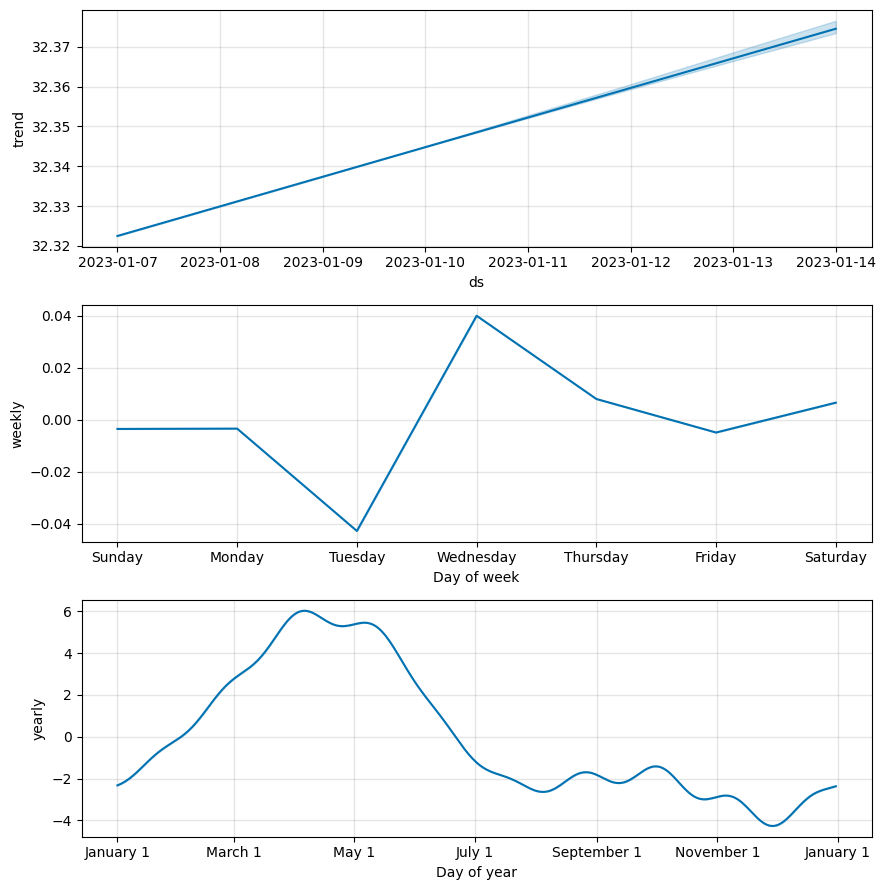

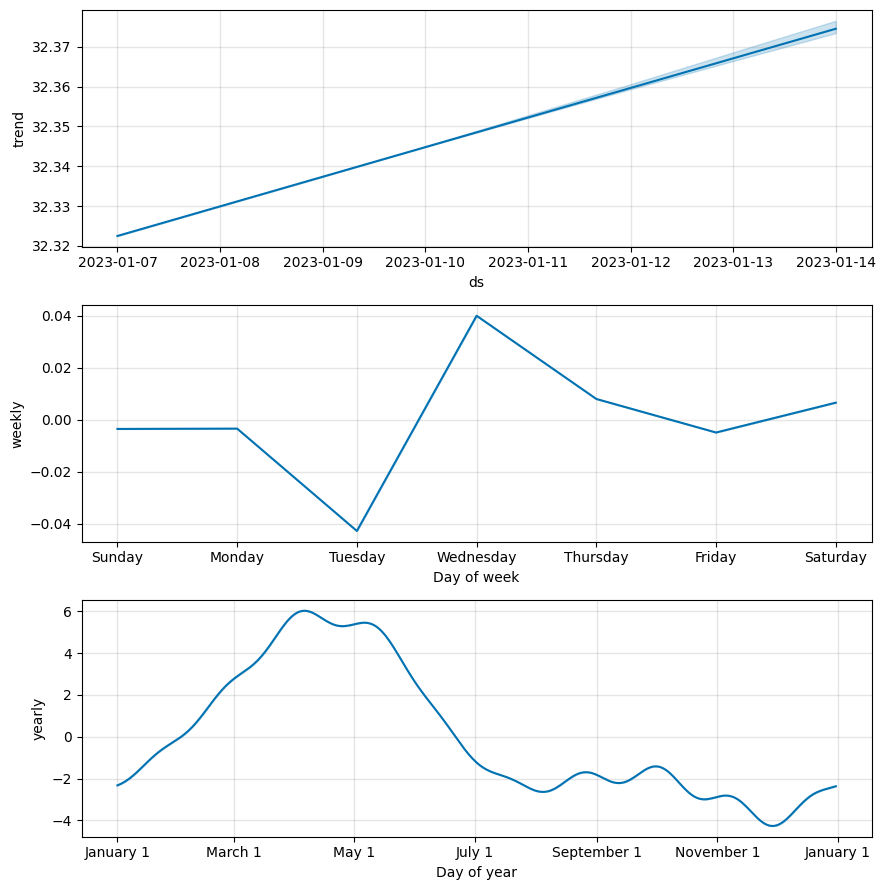

In [69]:
model.plot_components(fore)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
ax = df.set_index('ds').plot(figsize=(16, 8))
ax.set_ylabel('Temperature')
ax.set_xlabel('Date')

plt.show()

In [ ]:
prophet_model= Prophet(interval_width=0.90)

In [ ]:
prophet_model.fit(df)

In [ ]:
future_dates = prophet_model.make_future_dataframe(periods=10, freq='MS')

In [ ]:
forecast = prophet_model.predict(future_dates)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
prophet_model.plot(forecast, uncertainty=True)

In [ ]:
prophet_model.plot_components(forecast)